# Evaluating Persistent Memory based Range Indexes (VLDB 2020)

## Requirements
Here we import the libraries required by most of the scripts below.

In [2]:
import glob         # Unix style pathname pattern expansion
import re           # for regular expressions
import numpy        # for mathematical functions
import pandas as pd # for manipulating imported data
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML
from collections import defaultdict

## Input
Fill the path to raw data below:

In [1]:
output_regular_dir = "raw/20191011-024803"      # Folder with regular output files
output_skew_dir = "raw/20191013-120444_skew"    # Folder with varying skew output files
output_long_dir = "raw/20191014-015716_long"    # Folder with long recors output files

Create folder to generate plots into:

In [37]:
import os
os.mkdir("plots")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'plots'

Define some style options for matplotlib

In [4]:
def my_style():
    plt.style.use("default")
    
    #### AXES
    plt.rcParams["axes.grid"] = True
    plt.rcParams["axes.grid.axis"] = "y"
    plt.rcParams["axes.titlesize"] = "small"
    plt.rcParams["axes.titlepad"] = 2
    plt.rcParams["axes.labelsize"] = "small"
    plt.rcParams["axes.labelpad"] = 2
    plt.rcParams["axes.axisbelow"] = True            # draw axis gridlines and ticks below patches
    
    #### TICKS
    plt.rcParams["ytick.major.pad"] = 1
    plt.rcParams["xtick.major.pad"] = 1
    
    plt.rcParams["errorbar.capsize"] = 2
    plt.rcParams["ytick.direction"] = "in"
    plt.rcParams["xtick.direction"] = "in"
    plt.rcParams["ytick.labelsize"] = "small"
    plt.rcParams["xtick.labelsize"] = "small"
    
    plt.rcParams["grid.linestyle"] = "dotted"
    plt.rcParams["pdf.compression"] = False
    plt.rcParams["font.family"] ="sans-serif"
    plt.rcParams["font.sans-serif"] = ["Calibri"]
    plt.rcParams["font.size"] = 10
    
    plt.rcParams["hatch.linewidth"] = 0.3

    #### PATCHES
    plt.rcParams["patch.linewidth"] = 0.3
    plt.rcParams["patch.edgecolor"] = "black"
    plt.rcParams["patch.force_edgecolor"] = True
    
    #### LINES
    plt.rcParams["lines.markeredgecolor"] = "black"
    plt.rcParams["lines.markersize"] = 4
    plt.rcParams["lines.markeredgewidth"] = 0.5

    plt.rcParams["hatch.linewidth"] = 0.3

    #### LEGEND
    plt.rcParams["legend.frameon"] = False
    plt.rcParams["legend.fontsize"] = "small"
    plt.rcParams["legend.borderpad"] = 0.1
    plt.rcParams["legend.borderaxespad"] = 0.05
    plt.rcParams["legend.handletextpad"] = 0.4

## Parsing raw data into dictionaries

In [5]:
files = glob.glob(output_regular_dir+"/output_*.txt")

# File names should have the following format:
#    output_[latecy]_[distribution]_[workload]_[tree]_[threads]threads.txt
# Where:
#    [latency] = [0.0, 1.0]
#    [distribution] = {uniform, selfsimilar, zipfian}
#    [workload] = {read, insert, update, remove, scan, readheavy, balanced, writeheavy}
#    [tree] = {fptree, nvtree, wbtree, bztree}
#    [threads] = [1, 47]

# throughputs[latency][distribution][workload][tree_avg][threads]
throughputs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))

# latencies[latency][distribution][workload][tree_avg][threads]
latencies = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))))

# pcm[latency][distribution][workload][tree_avg][threads]
pcm = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))))
for f in files:
    # List to collect amount of operations completed per time window
    tputs = []
    
    # Parse the name of workload and tree from the file name.
    match_workload = re.search(".*output_(?P<latency>(1\.0|0\.\d+))_(?P<distribution>\w+)_(?P<workload>\w+)_(?P<tree>\w+)_\d+threads.txt", f)
    if match_workload is None:
        print("Error: file does not match pattern.")

    has_latencies = False
    for line in open(f,"r"):
        # Get the number of operations to calculate L3 Misses/op and KB/op
        match_operations = re.search("^\t# Operations: (?P<operations>\d+)$", line)
        if match_operations is not None:
            operations = int(match_operations.group("operations"))
            continue
        
        # Get the number of threads
        match_threads = re.search("^\t# Threads: (?P<threads>\d+)$", line)
        if match_threads is not None:
            threads = int(match_threads.group("threads"))
            continue

        # Get sampling rate to calculate throughput later
        match_sampling = re.search("^\tSampling: (?P<sampling>\d+) ms$", line)
        if match_sampling is not None:
            sampling = int(match_sampling.group("sampling"))
            continue

        # Get the latency sampling rate to check later if we should look for tail latency metrics
        match_latency = re.search("^\tLatency: (?P<lat_rate>(0|1|0\.\d+))$", line)
        if match_latency is not None:
            lat_rate = float(match_latency.group("lat_rate"))
            has_latencies = True
            continue
            
        # Get throughput observations
        match_tput = re.search("^\t(?P<tput>\d+)$", line)
        if match_tput is not None:
            tputs.append(int(match_tput.group("tput")))
            continue

        # Get PCM stats. Convert to L3 Misses/op and KB/op
        match_L3_misses = re.search("^\tL3 misses: (?P<L3_misses>\d+)$", line);
        if match_L3_misses is not None:
            pcm[match_workload.group("latency")][match_workload.group("distribution")][match_workload.group("workload")]["L3 Misses"][match_workload.group("tree")][threads] = int(match_L3_misses.group("L3_misses")) / operations
            continue
        
        match_dram_reads = re.search("^\tDRAM Reads \(bytes\): (?P<dram_reads>\d+)$", line);
        if match_dram_reads is not None:
            pcm[match_workload.group("latency")][match_workload.group("distribution")][match_workload.group("workload")]["DRAM Reads"][match_workload.group("tree")][threads] = int(match_dram_reads.group("dram_reads")) / 1024 / operations
            continue
        
        match_dram_writes = re.search("^\tDRAM Writes \(bytes\): (?P<dram_writes>\d+)$", line);
        if match_dram_writes is not None:
            pcm[match_workload.group("latency")][match_workload.group("distribution")][match_workload.group("workload")]["DRAM Writes"][match_workload.group("tree")][threads] = int(match_dram_writes.group("dram_writes")) / 1024 / operations
            continue
        
        match_nvm_reads = re.search("^\tNVM Reads \(bytes\): (?P<nvm_reads>\d+)$", line);
        if match_nvm_reads is not None:
            pcm[match_workload.group("latency")][match_workload.group("distribution")][match_workload.group("workload")]["PM Reads"][match_workload.group("tree")][threads] = int(match_nvm_reads.group("nvm_reads")) / 1024 / operations
            continue
        
        match_nvm_writes = re.search("^\tNVM Writes \(bytes\): (?P<nvm_writes>\d+)$", line);
        if match_nvm_writes is not None:
            pcm[match_workload.group("latency")][match_workload.group("distribution")][match_workload.group("workload")]["PM Writes"][match_workload.group("tree")][threads] = int(match_nvm_writes.group("nvm_writes")) / 1024 / operations
            continue
            
        match_ipmwatch_reads = re.search("^\tBytes Read: (?P<ipmwatch_reads>\d+)$", line);
        if match_ipmwatch_reads is not None:
            pcm[match_workload.group("latency")][match_workload.group("distribution")][match_workload.group("workload")]["ipmwatch Reads"][match_workload.group("tree")][threads] = int(match_ipmwatch_reads.group("ipmwatch_reads")) / 1024 / operations
            continue
        
        match_ipmwatch_writes = re.search("^\tBytes Written: (?P<ipmwatch_writes>\d+)$", line);
        if match_ipmwatch_writes is not None:
            pcm[match_workload.group("latency")][match_workload.group("distribution")][match_workload.group("workload")]["ipmwatch Writes"][match_workload.group("tree")][threads] = int(match_ipmwatch_writes.group("ipmwatch_writes")) / 1024 / operations
            continue
            
        # Get tail latency percentiles
        if(has_latencies):
            match_lat_min = re.search("^\tmin: (?P<lat_min>\d+)$", line);
            if match_lat_min is not None:
                latencies[str(match_workload.group("latency"))][match_workload.group("distribution")][match_workload.group("workload")][threads][match_workload.group("tree")]["min"] = int(match_lat_min.group("lat_min"))
                continue

            match_lat_50 = re.search("^\t50%: (?P<lat_50>\d+)$", line);
            if match_lat_50 is not None:
                latencies[str(match_workload.group("latency"))][match_workload.group("distribution")][match_workload.group("workload")][threads][match_workload.group("tree")]["50%"] = int(match_lat_50.group("lat_50"))
                continue
                
            match_lat_90 = re.search("^\t90%: (?P<lat_90>\d+)$", line);
            if match_lat_90 is not None:
                latencies[str(match_workload.group("latency"))][match_workload.group("distribution")][match_workload.group("workload")][threads][match_workload.group("tree")]["90%"] = int(match_lat_90.group("lat_90"))
                continue

            match_lat_99 = re.search("^\t99%: (?P<lat_99>\d+)$", line);
            if match_lat_99 is not None:
                latencies[str(match_workload.group("latency"))][match_workload.group("distribution")][match_workload.group("workload")][threads][match_workload.group("tree")]["99%"] = int(match_lat_99.group("lat_99"))
                continue

            match_lat_999 = re.search("^\t99\.9%: (?P<lat_999>\d+)$", line);
            if match_lat_999 is not None:
                latencies[str(match_workload.group("latency"))][match_workload.group("distribution")][match_workload.group("workload")][threads][match_workload.group("tree")]["99.9%"] = int(match_lat_999.group("lat_999"))
                continue

            match_lat_9999 = re.search("^\t99\.99%: (?P<lat_9999>\d+)$", line);
            if match_lat_9999 is not None:
                latencies[str(match_workload.group("latency"))][match_workload.group("distribution")][match_workload.group("workload")][threads][match_workload.group("tree")]["99.99%"] = int(match_lat_9999.group("lat_9999"))
                continue

            match_lat_99999 = re.search("^\t99\.999%: (?P<lat_99999>\d+)$", line);
            if match_lat_99999 is not None:
                latencies[str(match_workload.group("latency"))][match_workload.group("distribution")][match_workload.group("workload")][threads][match_workload.group("tree")]["99.999%"] = int(match_lat_99999.group("lat_99999"))
                continue

            match_lat_max = re.search("^\tmax: (?P<lat_max>\d+)$", line);
            if match_lat_max is not None:
                latencies[str(match_workload.group("latency"))][match_workload.group("distribution")][match_workload.group("workload")][threads][match_workload.group("tree")]["max"] = int(match_lat_max.group("lat_max"))
                continue

    # Aggregate tput and convert to million operations per second
    throughputs[match_workload.group("latency")][match_workload.group("distribution")][match_workload.group("workload")][match_workload.group("tree")+"_avg"][threads] = numpy.mean(tputs) * (1000 / sampling) / 1e6
    throughputs[match_workload.group("latency")][match_workload.group("distribution")][match_workload.group("workload")][match_workload.group("tree")+"_sd"][threads] = numpy.std(tputs) * (1000 / sampling) / 1e6

In [6]:
files = glob.glob(output_skew_dir+"/output_0.0_*.txt")

throughputs_skew = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for f in files:
    # List to collect amount of operations completed per time window
    tputs = []
    
    # Parse the name of workload and tree from the file name.
    match_workload = re.search(".*output_0.0_selfsimilar_(?P<skew>0\.\d)_(?P<workload>\w+)_(?P<tree>\w+)_\d+threads.txt", f)
    if match_workload is None:
        print("Error: file does not match pattern.")

    for line in open(f,"r"):
        # Get the number of threads
        match_threads = re.search("^\t# Threads: (?P<threads>\d+)$", line)
        if match_threads is not None:
            threads = int(match_threads.group("threads"))

        # Get sampling rate to calculate throughput later
        match_sampling = re.search("^\tSampling: (?P<sampling>\d+) ms$", line)
        if match_sampling is not None:
            sampling = int(match_sampling.group("sampling"))
            
        # Get throughput observations
        match_tput = re.search("^\t(?P<tput>\d+)$", line)
        if match_tput is not None:
            tputs.append(int(match_tput.group("tput")))

    # Aggregate tput and convert to million operations per second
    throughputs_skew[match_workload.group("workload")][threads][match_workload.group("tree")+"_avg"][match_workload.group("skew")] = numpy.mean(tputs) * (1000 / sampling) / 1e6
    throughputs_skew[match_workload.group("workload")][threads][match_workload.group("tree")+"_sd"][match_workload.group("skew")] = numpy.std(tputs) * (1000 / sampling) / 1e6

# Since wBTree is not multithread we copy the single thread results to facilitate the plotting later
throughputs_skew["read"][23]["wbtree_avg"] = throughputs_skew["read"][1]["wbtree_avg"]
throughputs_skew["read"][23]["wbtree_sd"] = throughputs_skew["read"][1]["wbtree_sd"]
throughputs_skew["update"][23]["wbtree_avg"] = throughputs_skew["update"][1]["wbtree_avg"]
throughputs_skew["update"][23]["wbtree_sd"] = throughputs_skew["update"][1]["wbtree_sd"]

# Throughput

### Parsed Data

In [7]:
tab_lat = widgets.Tab()
children_lat = []
for lat in throughputs:
    tab_dist = widgets.Tab()
    children_dist = []
    for dist in throughputs[lat]:
        tab_workload = widgets.Tab()
        children_workload = []
        for workload in throughputs[lat][dist]:
            df = pd.DataFrame(throughputs[lat][dist][workload])
            df = df.sort_index()

            out = widgets.Output(description="")
            out.append_display_data(HTML(df.to_html()))
            children_workload.append(out)

            tab_workload.set_title(list(throughputs[lat][dist]).index(workload), workload)
        tab_workload.children = children_workload

        children_dist.append(tab_workload)
        tab_dist.set_title(list(throughputs[lat]).index(dist), dist)
    tab_dist.children = children_dist
    
    children_lat.append(tab_dist)
    tab_lat.set_title(list(throughputs).index(lat), lat)

tab_lat.children = children_lat
tab_lat

### Plot Uniform Single Thread

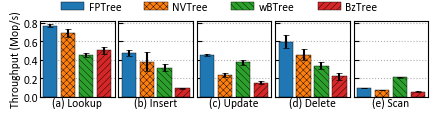

In [8]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (4.27, 1.0)
plt.rcParams["figure.subplot.left"] = 0.085
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.12
plt.rcParams["figure.subplot.top"] = 0.88
plt.rcParams["figure.subplot.wspace"] = 0.05

plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.labelbottom"] = False

plt.subplot(1,5,1)

plt.ylabel("Throughput (Mop/s)")

plt.title("(a) Lookup", y=-0.16)
df = pd.DataFrame(throughputs[str(0.0)]["uniform"]["read"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")
plt.bar(3, df.filter(like="bztree").iloc[0][0], yerr=df.filter(like="bztree").iloc[0][1], label="BzTree", hatch="/////")

ax = plt.gca()
ax.yaxis.set_ticks(numpy.arange(0.0, 0.85, 0.2))

plt.subplot(1,5,2, sharey=ax)
plt.title("(b) Insert", y=-0.16)
df = pd.DataFrame(throughputs[str(0.0)]["uniform"]["insert"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")
plt.bar(3, df.filter(like="bztree").iloc[0][0], yerr=df.filter(like="bztree").iloc[0][1], label="BzTree", hatch="/////")

plt.subplot(1,5,3, sharey=ax)
plt.title("(c) Update", y=-0.16)
df = pd.DataFrame(throughputs[str(0.0)]["uniform"]["update"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")
plt.bar(3, df.filter(like="bztree").iloc[0][0], yerr=df.filter(like="bztree").iloc[0][1], label="BzTree", hatch="/////")

plt.subplot(1,5,4, sharey=ax)
plt.title("(d) Delete", y=-0.16)
df = pd.DataFrame(throughputs[str(0.0)]["uniform"]["remove"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")
plt.bar(3, df.filter(like="bztree").iloc[0][0], yerr=df.filter(like="bztree").iloc[0][1], label="BzTree", hatch="/////")

plt.subplot(1,5,5, sharey=ax)
plt.title("(e) Scan", y=-0.16)
df = pd.DataFrame(throughputs[str(0.0)]["uniform"]["scan"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")
plt.bar(3, df.filter(like="bztree").iloc[0][0], yerr=df.filter(like="bztree").iloc[0][1], label="BzTree", hatch="/////")

# Remove yticklabels from all plots but the first one
for ax in plt.gcf().get_axes()[1:]:
    plt.setp(ax.get_yticklabels(), visible=False)

handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc="upper center", ncol=4)

plt.savefig("plots/plot_tput_uniform_single.pdf")

### Plot Skewed Single Thread

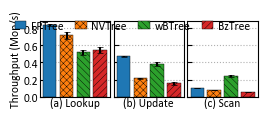

In [9]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (2.52, 1.0)
plt.rcParams["figure.subplot.left"] = 0.13
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.12
plt.rcParams["figure.subplot.top"] = 0.88
plt.rcParams["figure.subplot.wspace"] = 0.05

plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.labelbottom"] = False

plt.subplot(1,3,1)

plt.ylabel("Throughput (Mop/s)")

plt.title("(a) Lookup", y=-0.16)
df = pd.DataFrame(throughputs[str(0.0)]["selfsimilar"]["read"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")
plt.bar(3, df.filter(like="bztree").iloc[0][0], yerr=df.filter(like="bztree").iloc[0][1], label="BzTree", hatch="/////")

ax = plt.gca()
ax.yaxis.set_ticks(numpy.arange(0.0, 0.85, 0.2))

plt.subplot(1,3,2, sharey=ax)
plt.title("(b) Update", y=-0.16)
df = pd.DataFrame(throughputs[str(0.0)]["selfsimilar"]["update"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")
plt.bar(3, df.filter(like="bztree").iloc[0][0], yerr=df.filter(like="bztree").iloc[0][1], label="BzTree", hatch="/////")

plt.subplot(1,3,3, sharey=ax)
plt.title("(c) Scan", y=-0.16)
df = pd.DataFrame(throughputs[str(0.0)]["selfsimilar"]["scan"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")
plt.bar(3, df.filter(like="bztree").iloc[0][0], yerr=df.filter(like="bztree").iloc[0][1], label="BzTree", hatch="/////")

# Remove yticklabels from all plots but the first one
for ax in plt.gcf().get_axes()[1:]:
    plt.setp(ax.get_yticklabels(), visible=False)

handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc="upper center", ncol=4, handlelength=1, columnspacing=1, bbox_to_anchor=(0.025, 0, 1, 1))

plt.savefig("plots/plot_tput_selfsimilar_single.pdf")

### Plot Uniform Multiple Threads

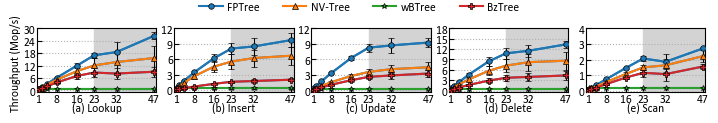

In [10]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (7.0, 1.0)
plt.rcParams["figure.subplot.left"] = 0.04
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.21
plt.rcParams["figure.subplot.top"] = 0.85
plt.rcParams["figure.subplot.wspace"] = 0.15

plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["xtick.labelsize"] = "small"

translate_tree = {
    "fptree" : "FPTree",
    "nvtree" : "NV-Tree",
    "wbtree" : "wBTree",
    "bztree" : "BzTree"
}

translate_workload = {
    "read" : "(a) Lookup",
    "insert" : "(b) Insert",
    "update" : "(c) Update",
    "remove" : "(d) Delete",
    "scan" : "(e) Scan"
}

workloads = ["read", "insert", "update", "remove", "scan"]
for wl in workloads:
    df = pd.DataFrame(throughputs[str(0.0)]["uniform"][wl])
    df = df.sort_index()
    df = df.fillna(value={"wbtree_avg" : df["wbtree_avg"].iloc[0], "wbtree_sd" : df["wbtree_sd"].iloc[0]})
    
    # DataFrame.plot() requires the error dataframe to have columns with the name name as the data.
    avg_df = df.filter(like="_avg").rename(columns=lambda s: s.replace("_avg", "")).rename(columns=translate_tree)
    err_df = df.filter(like="_sd").rename(columns=lambda s: s.replace("_sd","")).rename(columns=translate_tree)
    
    # Plotting
    ax = plt.subplot(1,5,workloads.index(wl)+1)
    ax = avg_df.plot.line(y=["FPTree", "NV-Tree", "wBTree", "BzTree"], yerr=err_df, legend=False, ecolor="black", elinewidth=0.75, ax=ax, zorder=3)
    ax = avg_df.plot(y=["FPTree", "NV-Tree", "wBTree", "BzTree"], style=["-o", "-^", "-*", "-P"], legend=False, ax=ax, zorder=4)
    
    ax.set_title(translate_workload[wl], y=-0.335)
    ax.xaxis.grid(False)
    ax.xaxis.set_ticks([1,8,16,23,32,47])
    ax.set_xlim(0,48)
    
    # Shaded area indicating hyperthreading zone
    plt.axvspan(xmin=23, xmax=ax.get_xlim()[1] , color="lightgrey", zorder=0)

plt.gcf().get_axes()[0].set_ylabel("Throughput (Mop/s)  ")

# Manually set yticks
plt.gcf().get_axes()[0].yaxis.set_ticks(numpy.arange(0, 36, 6))
plt.gcf().get_axes()[1].yaxis.set_ticks(numpy.arange(0, 14, 3))
plt.gcf().get_axes()[2].yaxis.set_ticks(numpy.arange(0, 14, 3))
plt.gcf().get_axes()[3].yaxis.set_ticks(numpy.arange(0, 21, 3))
plt.gcf().get_axes()[4].yaxis.set_ticks(numpy.arange(0, 5, 1))

handles, labels = plt.gca().get_legend_handles_labels()
handles_without_errorbars = list(filter(lambda elm: not isinstance(elm, matplotlib.container.ErrorbarContainer), handles))
plt.gcf().legend(handles_without_errorbars, labels, loc="upper center", ncol=4)

plt.savefig("plots/plot_tput_uniform_multi.pdf")

### Plot Skewed Multiple Threads

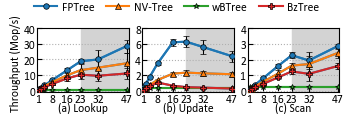

In [11]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (3.33, 1.0)
plt.rcParams["figure.subplot.left"] = 0.08
plt.rcParams["figure.subplot.right"] = 0.989
plt.rcParams["figure.subplot.bottom"] = 0.21
plt.rcParams["figure.subplot.top"] = 0.85
plt.rcParams["figure.subplot.wspace"] = 0.15

fig, axes = plt.subplots(nrows=1, ncols=3)

translate_tree = {
    "fptree" : "FPTree",
    "nvtree" : "NV-Tree",
    "wbtree" : "wBTree",
    "bztree" : "BzTree"
}

translate_workload = {
    "read" : "(a) Lookup",
    "update" : "(b) Update",
    "scan" : "(c) Scan"
}

workloads = ["read", "update", "scan"]
for wl in workloads:
    df = pd.DataFrame(throughputs[str(0.0)]["selfsimilar"][wl])
    df = df.sort_index()
    df = df.fillna(value={"wbtree_avg" : df["wbtree_avg"].iloc[0], "wbtree_sd" : df["wbtree_sd"].iloc[0]})
    
    # DataFrame.plot() requires the error dataframe to have columns with the name name as the data.
    avg_df = df.filter(like="_avg").rename(columns=lambda s: s.replace("_avg", "")).rename(columns=translate_tree)
    err_df = df.filter(like="_sd").rename(columns=lambda s: s.replace("_sd","")).rename(columns=translate_tree)
    
    # Plotting
    ax = plt.subplot(1,3,workloads.index(wl)+1)
    ax = avg_df.plot.line(y=["FPTree", "NV-Tree", "wBTree", "BzTree"], yerr=err_df, legend=False, ecolor="black", elinewidth=0.75, ax=ax, zorder=3)
    ax = avg_df.plot(y=["FPTree", "NV-Tree", "wBTree", "BzTree"], style=["-o", "-^", "-*", "-P"], legend=False, ax=ax, zorder=4)
    
    ax.set_title(translate_workload[wl], y=-0.335)
    ax.xaxis.grid(False)
    ax.xaxis.set_ticks([1,8,16,23,32,47])
    ax.set_xlim(0,48)
    
    # Shaded area indicating hyperthreading zone
    plt.axvspan(xmin=23, xmax=ax.get_xlim()[1] , color="lightgrey", zorder=0)

plt.gcf().get_axes()[0].set_ylabel("Throughput (Mop/s)  ")

# Manually set yticks
plt.gcf().get_axes()[0].yaxis.set_ticks(numpy.arange(0, 41, 10))
plt.gcf().get_axes()[1].yaxis.set_ticks(numpy.arange(0, 9, 2))
plt.gcf().get_axes()[2].yaxis.set_ticks(numpy.arange(0, 5, 1))

handles, labels = plt.gca().get_legend_handles_labels()
handles_without_errorbars = list(filter(lambda elm: not isinstance(elm, matplotlib.container.ErrorbarContainer), handles))
plt.gcf().legend(handles_without_errorbars, labels, loc="upper center", ncol=4, handlelength=2, columnspacing=1.0)

plt.savefig("plots/plot_tput_selfsimilar_multi.pdf")

### Plot Mixed Workloads Uniform and Skewed Multiple Threads

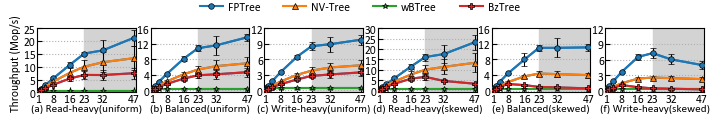

In [12]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (7.0, 1.0)
plt.rcParams["figure.subplot.left"] = 0.04
plt.rcParams["figure.subplot.right"] = 0.993
plt.rcParams["figure.subplot.bottom"] = 0.21
plt.rcParams["figure.subplot.top"] = 0.85
plt.rcParams["figure.subplot.wspace"] = 0.15

translate_tree = {
    "fptree" : "FPTree",
    "nvtree" : "NV-Tree",
    "wbtree" : "wBTree",
    "bztree" : "BzTree"
}

translate_workload = {
    ("uniform","readheavy") : "(a) Read-heavy(uniform)",
    ("uniform", "balanced") : "(b) Balanced(uniform)",
    ("uniform", "writeheavy") : "(c) Write-heavy(uniform)",
    ("selfsimilar","readheavy") : "(d) Read-heavy(skewed)",
    ("selfsimilar", "balanced") : "(e) Balanced(skewed)",
    ("selfsimilar", "writeheavy") : "(f) Write-heavy(skewed)"
}

workloads = [("uniform","readheavy"), ("uniform", "balanced"), ("uniform", "writeheavy"), ("selfsimilar","readheavy"), ("selfsimilar", "balanced"), ("selfsimilar", "writeheavy")]
for wl in workloads:
    df = pd.DataFrame(throughputs[str(0.0)][wl[0]][wl[1]])
    df = df.sort_index()
    df = df.fillna(value={"wbtree_avg" : df["wbtree_avg"].iloc[0], "wbtree_sd" : df["wbtree_sd"].iloc[0]})
    
    # DataFrame.plot() requires the error dataframe to have columns with the name name as the data.
    avg_df = df.filter(like="_avg").rename(columns=lambda s: s.replace("_avg", "")).rename(columns=translate_tree)
    err_df = df.filter(like="_sd").rename(columns=lambda s: s.replace("_sd","")).rename(columns=translate_tree)
    
    # Plotting
    ax = plt.subplot(1,6,workloads.index(wl)+1)
    ax = avg_df.plot.line(y=["FPTree", "NV-Tree", "wBTree", "BzTree"], yerr=err_df, legend=False, ecolor="black", elinewidth=0.75, ax=ax, zorder=3)
    ax = avg_df.plot(y=["FPTree", "NV-Tree", "wBTree", "BzTree"], style=["-o", "-^", "-*", "-P"], legend=False, ax=ax, zorder=4)
    
    ax.set_title(translate_workload[wl], fontsize=8, y=-0.335)
    ax.xaxis.grid(False)
    ax.xaxis.set_ticks([1,8,16,23,32,47])
    ax.set_xlim(0,48)

    # Shaded area indicating hyperthreading zone
    plt.axvspan(xmin=23, xmax=ax.get_xlim()[1] , color="lightgrey", zorder=0)

plt.gcf().get_axes()[0].set_ylabel("Throughput (Mop/s)  ",)

# Manually set yticks
plt.gcf().get_axes()[0].yaxis.set_ticks(numpy.arange(0, 26, 5))
plt.gcf().get_axes()[0].set_ylim(0,25)
plt.gcf().get_axes()[1].yaxis.set_ticks(numpy.arange(0, 17, 4))
plt.gcf().get_axes()[2].yaxis.set_ticks(numpy.arange(0, 13, 3))
plt.gcf().get_axes()[3].yaxis.set_ticks(numpy.arange(0, 31, 5))
plt.gcf().get_axes()[4].yaxis.set_ticks(numpy.arange(0, 17, 4))
plt.gcf().get_axes()[5].yaxis.set_ticks(numpy.arange(0, 13, 3))


handles, labels = plt.gca().get_legend_handles_labels()
handles_without_errorbars = list(filter(lambda elm: not isinstance(elm, matplotlib.container.ErrorbarContainer), handles))
plt.gcf().legend(handles_without_errorbars, labels, loc="upper center", ncol=4)

plt.savefig("plots/plot_tput_mixed.pdf")

### Parsed Data (Variable Skew)

In [13]:
tab_workload = widgets.Tab()
children_workload = []
for workload in throughputs_skew:
    tab_threads = widgets.Tab()
    children_threads = []
    for threads in throughputs_skew[workload]:
        df = pd.DataFrame(throughputs_skew[workload][threads])
        df = df.sort_index()

        out = widgets.Output(description="")
        out.append_display_data(HTML(df.to_html()))
        children_threads.append(out)

        tab_threads.set_title(list(throughputs_skew[workload]).index(threads), str(threads))
    tab_threads.children = children_threads
    
    children_workload.append(tab_threads)
    tab_workload.set_title(list(throughputs_skew).index(workload), workload)

tab_workload.children = children_workload
tab_workload

### Plot Throughput with Variable Skew

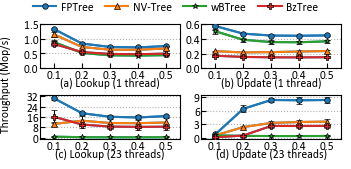

In [14]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (3.33, 1.5)
plt.rcParams["figure.subplot.left"] = 0.09
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.13
plt.rcParams["figure.subplot.top"] = 0.9
plt.rcParams["figure.subplot.wspace"] = 0.15
plt.rcParams["figure.subplot.hspace"] = 0.6

translate_tree = {
    "fptree" : "FPTree",
    "nvtree" : "NV-Tree",
    "wbtree" : "wBTree",
    "bztree" : "BzTree"
}

translate_workload = {
    ("read",1) : "(a) Lookup (1 thread)",
    ("update",1) : "(b) Update (1 thread)",
    ("read",23) : "(c) Lookup (23 threads)",
    ("update",23) : "(d) Update (23 threads)"
}

workloads = [("read",1), ("update",1), ("read",23), ("update",23)]
for wl in workloads:
    df = pd.DataFrame(throughputs_skew[wl[0]][wl[1]])
    df = df.sort_index()
    df = df.fillna(value={"wbtree_avg" : df["wbtree_avg"].iloc[0], "wbtree_sd" : df["wbtree_sd"].iloc[0]})
    
    # DataFrame.plot() requires the error dataframe to have columns with the name name as the data.
    avg_df = df.filter(like="_avg").rename(columns=lambda s: s.replace("_avg", "")).rename(columns=translate_tree)
    err_df = df.filter(like="_sd").rename(columns=lambda s: s.replace("_sd","")).rename(columns=translate_tree)
    
    # Plotting
    ax = plt.subplot(2,2,workloads.index(wl)+1)
    ax = avg_df.plot.line(y=["FPTree", "NV-Tree", "wBTree", "BzTree"], yerr=err_df, legend=False, ecolor="black", elinewidth=0.75, ax=ax, zorder=3)
    ax = avg_df.plot(y=["FPTree", "NV-Tree", "wBTree", "BzTree"], style=["-o", "-^", "-*", "-P"], legend=False, ax=ax, zorder=4)
    
    ax.set_title(translate_workload[wl], y=-0.46)
    ax.xaxis.grid(False)
    ax.set_xlim(-0.5, 4.5)  # For adding space at sides so lines don'd collide with spines

plt.annotate("Throughput (Mop/s)", (0, 0.5), xycoords="figure fraction", rotation="vertical", va="center", ha="left", fontsize="small")

# Manually set yticks
plt.gcf().get_axes()[0].yaxis.set_ticks(numpy.arange(0.0, 1.6, 0.5))
plt.gcf().get_axes()[1].yaxis.set_ticks(numpy.arange(0.0, 0.7, 0.2))
plt.gcf().get_axes()[2].yaxis.set_ticks(numpy.arange(0, 33, 8))
plt.gcf().get_axes()[3].yaxis.set_ticks(numpy.arange(0, 10, 3))

handles, labels = plt.gca().get_legend_handles_labels()
handles_without_errorbars = list(filter(lambda elm: not isinstance(elm, matplotlib.container.ErrorbarContainer), handles))
plt.gcf().legend(handles_without_errorbars, labels, loc="upper center", ncol=4, handlelength=2, columnspacing=1.0)

plt.savefig("plots/plot_tput_skew.pdf")

## PCM / ipmwatch

### Parsed Data

In [15]:
tab_lat = widgets.Tab()
children_lat = []
for lat in pcm:
    tab_dist = widgets.Tab()
    children_dist = []
    for dist in pcm[lat]:
        tab_workload = widgets.Tab()
        children_workload = []
        for workload in pcm[lat][dist]:
            tab_stat = widgets.Tab()
            children_stat = []
            for stat in pcm[lat][dist][workload]:
                df = pd.DataFrame(pcm[lat][dist][workload][stat])
                df = df.sort_index()

                out = widgets.Output(description="")
                out.append_display_data(HTML(df.to_html()))
                children_stat.append(out)

                tab_stat.set_title(list(pcm[lat][dist][workload]).index(stat), stat)

            tab_stat.children = children_stat
            children_workload.append(tab_stat)

            tab_workload.set_title(list(pcm[lat][dist]).index(workload), workload)

        tab_workload.children = children_workload

        children_dist.append(tab_workload)
        tab_dist.set_title(list(pcm[lat]).index(dist), dist)
    tab_dist.children = children_dist
    
    children_lat.append(tab_dist)
    tab_lat.set_title(list(pcm).index(lat), lat)
tab_lat.children = children_lat
tab_lat

### Memory Traffic Plots

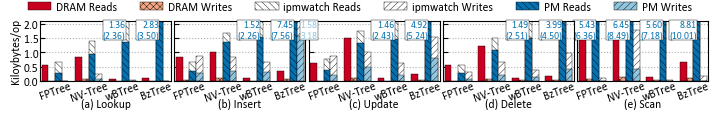

In [16]:
%matplotlib inline

from matplotlib.colors import LinearSegmentedColormap

my_style()

plt.rcParams["figure.figsize"] = (7.0, 1.0)
plt.rcParams["figure.subplot.left"] = 0.0425
plt.rcParams["figure.subplot.right"] = 0.9975
plt.rcParams["figure.subplot.bottom"] = 0.275
plt.rcParams["figure.subplot.top"] = 0.88
plt.rcParams["figure.subplot.wspace"] = 0.025

plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.major.pad"] = -1

blue_red1 = LinearSegmentedColormap.from_list("BlueRed1", ["#ca0020", "#f4a582", "#ffffff", "#ffffff"])
blue_red2 = LinearSegmentedColormap.from_list("BlueRed2", ["#0571b0", "#92c5de"])

plt.subplots(1,5)

bar_width = 0.2
max_y = 2.0

translate_tree = {
    "fptree" : "FPTree",
    "nvtree" : "NV-Tree",
    "wbtree" : "wBTree",
    "bztree" : "BzTree"
}

translate_workload = {
    "read" : "(a) Lookup",
    "insert" : "(b) Insert",
    "update" : "(c) Update",
    "remove" : "(d) Delete",
    "scan" : "(e) Scan"
}

workloads = ["read", "insert", "update", "remove", "scan"]
for wl in workloads:
    # Create dataframe
    d = {}
    for stat in pcm[str(0.0)]["uniform"][wl]:
        d[stat] = pd.DataFrame(pcm[str(0.0)]["uniform"][wl][stat])

    df = pd.concat(d)
    df = df.unstack(level=0).stack(level=0).reset_index().rename(columns={"level_0" : "# Threads", "level_1" : "Tree"})

    df = df.loc[df["# Threads"] == 1]
    df = df.set_index("Tree").reindex(index=["fptree", "nvtree", "wbtree", "bztree"])
    df = df.rename(index=translate_tree)
    df = df.reset_index()

    # Plotting
    ax = plt.subplot(1,5,workloads.index(wl)+1, sharey=plt.gcf().get_axes()[0])
    
    ax = df.plot.bar(x="Tree", y=["DRAM Reads", "DRAM Writes", "ipmwatch Reads", "ipmwatch Writes"], colormap=blue_red1, position=0.5, width=bar_width*4, ax=ax)
    ax = df.plot.bar(x="Tree", y=["PM Reads", "PM Writes"], colormap=blue_red2, rot=20, position=0, width=bar_width*2, ax=ax)
    
    # Hacky way to allow annotations to overlap plots: set z-order from last to first
    ax.set_zorder(len(workloads) - workloads.index(wl))
    
    # Annotate bars above the limit
    for index, row in df.iterrows():
        if row["ipmwatch Reads"] > max_y:
            ax.text(
                index+bar_width*0.5,
                max_y+0.1,
                "%.2f\n(%.2f)" % (row["PM Reads"] ,row["ipmwatch Reads"]),
                ha="right", va="top", fontsize="x-small", color="#0571b0", zorder=11,
                bbox={"pad" : 0.125, "linewidth" : 0.3, "facecolor" : "white"})
        if row["ipmwatch Writes"] > max_y:
            ax.text(
                index+bar_width*1.5,
                max_y+0.1,
                "%.2f\n%.2f" % (row["PM Writes"] ,row["ipmwatch Writes"]),
                 ha="left", va="top", fontsize="x-small", color="#92c5de", zorder=11,
                 bbox={"pad" : 0.125, "linewidth" : 0.3, "facecolor" : "white", "zorder" : 11})
        
    ax.set_title(translate_workload[wl], y=-0.473)
    ax.get_legend().remove()
    ax.xaxis.label.set_visible(False)
    ax.xaxis.grid(False)
    ax.yaxis.set_ticks(numpy.arange(0.0, max_y+0.5, 0.5))
    ax.set_xlim(0-2*bar_width-0.05, 3+2*bar_width+0.05)
    ax.set_ylim(0.0, max_y+0.1)
    
    bars = ax.patches
    patterns =(" ", "xxxxx", "\\\\\\\\\\", "/////", "\\\\\\\\\\", "/////")
    hatches = [p for p in patterns for i in range(4)]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

plt.gcf().get_axes()[0].set_ylabel("Kiloybytes/op")

handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc="upper center", ncol=6)

plt.savefig("plots/plot_pcm_uniform.pdf")

### L3 Misses Plots

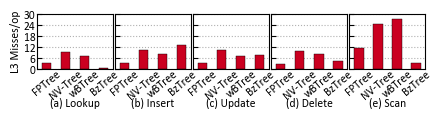

In [17]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (4.2, 1.0)
plt.rcParams["figure.subplot.left"] = 0.065
plt.rcParams["figure.subplot.right"] = 0.99
plt.rcParams["figure.subplot.bottom"] = 0.4
plt.rcParams["figure.subplot.top"] = 0.95
plt.rcParams["figure.subplot.wspace"] = 0.025

plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.major.pad"] = -1

fig, axes = plt.subplots(nrows=1, ncols=5)

translate_tree = {
    "fptree" : "FPTree",
    "nvtree" : "NV-Tree",
    "wbtree" : "wBTree",
    "bztree" : "BzTree"
}

translate_workload = {
    "read" : "(a) Lookup",
    "insert" : "(b) Insert",
    "update" : "(c) Update",
    "remove" : "(d) Delete",
    "scan" : "(e) Scan"
}

workloads = ["read", "insert", "update", "remove", "scan"]
for wl in workloads:
    # Create dataframe
    d = {}
    for stat in pcm[str(0.0)]["uniform"][wl]:
        d[stat] = pd.DataFrame(pcm[str(0.0)]["uniform"][wl][stat])

    df = pd.concat(d)
    df = df.unstack(level=0).stack(level=0).reset_index().rename(columns={"level_0" : "# Threads", "level_1" : "Tree"})

    df = df.loc[df["# Threads"] == 1]
    df = df.set_index("Tree").reindex(index=["fptree", "nvtree", "wbtree", "bztree"])
    df = df.rename(index=translate_tree)
    df = df.reset_index()

    # Plotting
    ax = plt.subplot(1,5,workloads.index(wl)+1, sharey=plt.gcf().get_axes()[0])
    ax = df.plot.bar(x="Tree", y="L3 Misses", color="#ca0020", rot=40, ax=ax)
    
    ax.set_title(translate_workload[wl], y=-0.74)
    ax.get_legend().remove()
    ax.xaxis.label.set_visible(False)
    ax.xaxis.grid(False)
    ax.yaxis.set_ticks(numpy.arange(0, 31, 6))
    ax.yaxis.set_ticks([], minor=True)

plt.gcf().get_axes()[0].set_ylabel("L3 Misses/op")

plt.savefig("plots/plot_L3_uniform.pdf")

## Tail Latencies

In [18]:
tab_lat = widgets.Tab()
children_lat = []
for lat in latencies:
    tab_dist = widgets.Tab()
    children_dist = []
    for dist in latencies[lat]:
        tab_workload = widgets.Tab()
        children_workload = []
        for workload in latencies[lat][dist]:
            tab_threads = widgets.Tab()
            children_threads = []
            for threads in latencies[lat][dist][workload]:
                df = pd.DataFrame(latencies[lat][dist][workload][threads])

                out = widgets.Output(description="")
                out.append_display_data(HTML(df.to_html()))
                children_threads.append(out)
                tab_threads.set_title(list(latencies[lat][dist][workload]).index(threads), str(threads))
            
            tab_threads.children = children_threads
            
            children_workload.append(tab_threads)
            tab_workload.set_title(list(latencies[lat][dist]).index(workload), workload)
        tab_workload.children = children_workload

        children_dist.append(tab_workload)
        tab_dist.set_title(list(latencies[lat]).index(dist), dist)
    tab_dist.children = children_dist
    
    children_lat.append(tab_dist)
    tab_lat.set_title(list(latencies).index(lat), lat)
tab_lat.children = children_lat
tab_lat

### Plot Tail Latency (Single Thread)

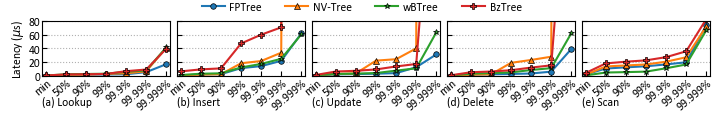

In [19]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (7.0, 1.0)
plt.rcParams["errorbar.capsize"] = 2
plt.rcParams["figure.subplot.left"] = 0.04
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.33
plt.rcParams["figure.subplot.top"] = 0.875
plt.rcParams["figure.subplot.wspace"] = 0.05

translate_tree = {
    "fptree" : "FPTree",
    "nvtree" : "NV-Tree",
    "wbtree" : "wBTree",
    "bztree" : "BzTree"
}

translate_workload = {
    "read" : "(a) Lookup",
    "insert" : "(b) Insert",
    "update" : "(c) Update",
    "remove" : "(d) Delete",
    "scan" : "(e) Scan"
}

workloads = ["read", "insert", "update", "remove", "scan"]
for wl in workloads:
    df = pd.DataFrame(latencies[str(0.1)]["uniform"][wl][1])    
    df = df.rename(columns=translate_tree)
    df = df / 1000 # Convert from nanoseconds to microseconds
    df = df.filter(items=["min","50%","90%","99%","99.9%","99.99%","99.999%"], axis="index")

    # Plotting
    ax = plt.subplot(1,5,workloads.index(wl)+1)
    ax = df.plot.line(
                      y=["FPTree", "NV-Tree", "wBTree", "BzTree"],
                      style=["-o", "-^", "-*", "-P"],
                      legend=False,
                      ax=ax,
                      xticks=numpy.arange(len(df.index)))
    
    ax.set_title(translate_workload[wl], fontsize="small", loc="left", y=-0.6)
    ax.xaxis.grid(False)
    plt.xticks(rotation=40, ha="right", va="top", rotation_mode="anchor")
    
    xmin,xmax = ax.get_xlim()
    ax.set_xlim(xmin-0.2, xmax+0.2)
    ax.set_ylim(0,80)
    ax.set_yticks(numpy.arange(0,81,20))

plt.gcf().get_axes()[0].set_ylabel("Latency ($\mu$s)")

handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc="upper center", ncol=4)

# Remove yticklabels from all plots but the first one
for ax in plt.gcf().get_axes()[1:]:
    plt.setp(ax.get_yticklabels(), visible=False)

plt.savefig("plots/plot_tail_uniform_0.1_1_thread.pdf")

### Plot Tail Latency (23 Threads)

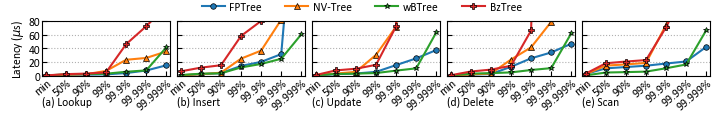

In [25]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (7.0, 1.0)
plt.rcParams["figure.subplot.left"] = 0.04
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.33
plt.rcParams["figure.subplot.top"] = 0.875
plt.rcParams["figure.subplot.wspace"] = 0.05

fig, axes = plt.subplots(nrows=1, ncols=5)

translate_tree = {
    "fptree" : "FPTree",
    "nvtree" : "NV-Tree",
    "wbtree" : "wBTree",
    "bztree" : "BzTree"
}

translate_workload = {
    "read" : "(a) Lookup",
    "insert" : "(b) Insert",
    "update" : "(c) Update",
    "remove" : "(d) Delete",
    "scan" : "(e) Scan"
}

# Since wBTree does not have multithread results, we copy the single thread number to facilitate plotting
latencies[str(0.1)]["uniform"][wl][23]["wbtree"] = latencies[str(0.1)]["uniform"][wl][1]["wbtree"]

workloads = ["read", "insert", "update", "remove", "scan"]
for wl in workloads:
    df = pd.DataFrame(latencies[str(0.1)]["uniform"][wl][23])
    df = df.rename(columns=translate_tree)
    df = df / 1000 # Convert from nanoseconds to microseconds
    df = df.filter(items=["min","50%","90%","99%","99.9%","99.99%","99.999%"], axis="index")

    # Plotting
    ax = plt.subplot(1,5,workloads.index(wl)+1)
    ax = df.plot.line(
                      y=["FPTree", "NV-Tree", "wBTree", "BzTree"],
                      style=["-o", "-^", "-*", "-P"],
                      legend=False,
                      ax=ax,
                      xticks=numpy.arange(len(df.index)))
    
    ax.set_title(translate_workload[wl], loc="left", y=-0.6)
    ax.xaxis.grid(False)
    plt.xticks(rotation=40, ha="right", va="top", rotation_mode="anchor")
    
    xmin,xmax = ax.get_xlim()
    ax.set_xlim(xmin-0.2, xmax+0.2)
    ax.set_ylim(0,80)
    ax.set_yticks(numpy.arange(0,81,20))

plt.gcf().get_axes()[0].set_ylabel("Latency ($\mu$s)")

handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc="upper center", ncol=4)

# Remove yticklabels from all plots but the first one
for ax in plt.gcf().get_axes()[1:]:
    plt.setp(ax.get_yticklabels(), visible=False)

plt.savefig("plots/plot_tail_uniform_0.1_23_thread.pdf")

## Long keys (20 Bytes) and values (100 Bytes)

In [26]:
files = glob.glob(output_long_dir+"/output_0.0_*.txt")

throughputs_long = defaultdict(lambda: defaultdict(dict))
for f in files:
    # List to collect amount of operations completed per time window
    tputs = []
    
    # Parse the name of workload and tree from the file name.
    match_workload = re.search(".*output_0\.0_uniform_(?P<workload>\w+)_(?P<tree>\w+)_\d+threads.txt", f)
    if match_workload is None:
        print("Error: file does not match pattern.")
        print(f)

    for line in open(f,"r"):
        # Get the number of threads
        match_threads = re.search("^\t# Threads: (?P<threads>\d+)$", line)
        if match_threads is not None:
            threads = int(match_threads.group("threads"))

        # Get sampling rate to calculate throughput later
        match_sampling = re.search("^\tSampling: (?P<sampling>\d+) ms$", line)
        if match_sampling is not None:
            sampling = int(match_sampling.group("sampling"))
            
        # Get throughput observations
        match_tput = re.search("^\t(?P<tput>\d+)$", line)
        if match_tput is not None:
            tputs.append(int(match_tput.group("tput")))

    # Aggregate tput and convert to million operations per second
    throughputs_long[match_workload.group("workload")][match_workload.group("tree")+"_avg"][threads] = numpy.mean(tputs) * (1000 / sampling) / 1e6
    throughputs_long[match_workload.group("workload")][match_workload.group("tree")+"_sd"][threads] = numpy.std(tputs) * (1000 / sampling) / 1e6

# Since wBTree is not multithread we copy the single thread results to facilitate the plotting later
#throughputs_long["read"][23]["wbtree_avg"] = throughputs_skew["read"][1]["wbtree_avg"]
#throughputs_long["read"][23]["wbtree_sd"] = throughputs_skew["read"][1]["wbtree_sd"]
#throughputs_long["update"][23]["wbtree_avg"] = throughputs_skew["update"][1]["wbtree_avg"]
#throughputs_long["update"][23]["wbtree_sd"] = throughputs_skew["update"][1]["wbtree_sd"]

In [27]:
tab_workload = widgets.Tab()
children_workload = []
for workload in throughputs_long:
    df = pd.DataFrame(throughputs_long[workload])
    df = df.sort_index()

    out = widgets.Output(description="")
    out.append_display_data(HTML(df.to_html()))
    children_workload.append(out)

    tab_workload.set_title(list(throughputs_long).index(workload), workload)
tab_workload.children = children_workload
tab_workload

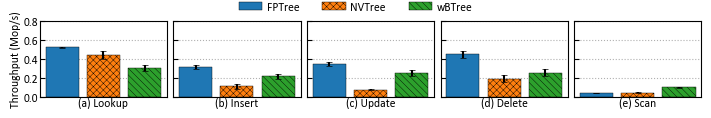

In [28]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (7.0, 1.0)
plt.rcParams["figure.subplot.left"] = 0.05
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.12
plt.rcParams["figure.subplot.top"] = 0.88
plt.rcParams["figure.subplot.wspace"] = 0.05

plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.labelbottom"] = False

plt.subplot(1,5,1)

plt.ylabel("Throughput (Mop/s)")

plt.title("(a) Lookup", y=-0.16)
df = pd.DataFrame(throughputs_long["read"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")

ax = plt.gca()
plt.ylim(0, 0.8)
ax.yaxis.set_ticks(numpy.arange(0.0, 0.81, 0.2))

plt.subplot(1,5,2, sharey=ax)
plt.title("(b) Insert", y=-0.16)
df = pd.DataFrame(throughputs_long["insert"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")

plt.subplot(1,5,3, sharey=ax)
plt.title("(c) Update", y=-0.16)
df = pd.DataFrame(throughputs_long["update"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")

plt.subplot(1,5,4, sharey=ax)
plt.title("(d) Delete", y=-0.16)
df = pd.DataFrame(throughputs_long["remove"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")

plt.subplot(1,5,5, sharey=ax)
plt.title("(e) Scan", y=-0.16)
df = pd.DataFrame(throughputs_long["scan"])
df = df.sort_index()
plt.bar(0, df.filter(like="fptree").iloc[0][0], yerr=df.filter(like="fptree").iloc[0][1], label="FPTree")
plt.bar(1, df.filter(like="nvtree").iloc[0][0], yerr=df.filter(like="nvtree").iloc[0][1], label="NVTree", hatch="xxxxx")
plt.bar(2, df.filter(like="wbtree").iloc[0][0], yerr=df.filter(like="wbtree").iloc[0][1], label="wBTree", hatch="\\\\\\\\\\")

# Remove yticklabels from all plots but the first one
for ax in plt.gcf().get_axes()[1:]:
    plt.setp(ax.get_yticklabels(), visible=False)

handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc="upper center", ncol=4)

plt.savefig("plots/plot_tput_uniform_single_long.pdf")

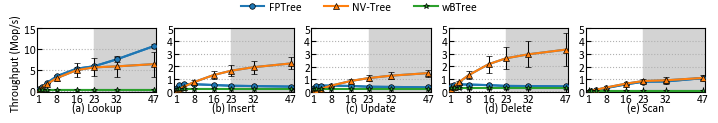

In [29]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (7.0, 1.0)
plt.rcParams["figure.subplot.left"] = 0.04
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.21
plt.rcParams["figure.subplot.top"] = 0.85
plt.rcParams["figure.subplot.wspace"] = 0.15

translate_tree = {
    "fptree" : "FPTree",
    "nvtree" : "NV-Tree",
    "wbtree" : "wBTree",
    "bztree" : "BzTree"
}

translate_workload = {
    "read" : "(a) Lookup",
    "insert" : "(b) Insert",
    "update" : "(c) Update",
    "remove" : "(d) Delete",
    "scan" : "(e) Scan"
}

workloads = ["read", "insert", "update", "remove", "scan"]
for wl in workloads:
    df = pd.DataFrame(throughputs_long[wl])
    df = df.sort_index()
    df = df.fillna(value={"wbtree_avg" : df["wbtree_avg"].iloc[0], "wbtree_sd" : df["wbtree_sd"].iloc[0]})
    
    # DataFrame.plot() requires the error dataframe to have columns with the name name as the data.
    avg_df = df.filter(like="_avg").rename(columns=lambda s: s.replace("_avg", "")).rename(columns=translate_tree)
    err_df = df.filter(like="_sd").rename(columns=lambda s: s.replace("_sd","")).rename(columns=translate_tree)
    
    # Plotting
    ax = plt.subplot(1,5,workloads.index(wl)+1)
    ax = avg_df.plot.line(y=["FPTree", "NV-Tree", "wBTree"], yerr=err_df, legend=False, ecolor="black", elinewidth=0.75, ax=ax, zorder=3)
    ax = avg_df.plot(y=["FPTree", "NV-Tree", "wBTree"], style=["-o", "-^", "-*"], legend=False, ax=ax, zorder=4)
    
    ax.set_title(translate_workload[wl], y=-0.335)
    ax.xaxis.grid(False)
    ax.xaxis.set_ticks([1,8,16,23,32,47])
    ax.set_xlim(0,48)
    
    # Shaded area indicating hyperthreading zone
    plt.axvspan(xmin=23, xmax=ax.get_xlim()[1] , color="lightgrey", zorder=0)

plt.gcf().get_axes()[0].set_ylabel("Throughput (Mop/s)  ")

# Manually set yticks
plt.gcf().get_axes()[0].yaxis.set_ticks(numpy.arange(0, 16, 5))
plt.gcf().get_axes()[1].yaxis.set_ticks(numpy.arange(0, 6, 1))
plt.gcf().get_axes()[2].yaxis.set_ticks(numpy.arange(0, 6, 1))
plt.gcf().get_axes()[3].yaxis.set_ticks(numpy.arange(0, 6, 1))
plt.gcf().get_axes()[4].yaxis.set_ticks(numpy.arange(0, 6, 1))

handles, labels = plt.gca().get_legend_handles_labels()
handles_without_errorbars = list(filter(lambda elm: not isinstance(elm, matplotlib.container.ErrorbarContainer), handles))
plt.gcf().legend(handles_without_errorbars, labels, loc="upper center", ncol=4)

plt.savefig("plots/plot_tput_uniform_multi_long.pdf")

## Memory Consumption

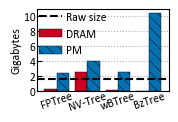

In [30]:
%matplotlib inline

from matplotlib.colors import LinearSegmentedColormap

my_style()

plt.rcParams["figure.figsize"] = (1.598, 1.0)
plt.rcParams["figure.subplot.left"] = 0.17
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.175
plt.rcParams["figure.subplot.top"] = 0.99
plt.rcParams["figure.subplot.wspace"] = 0.025

plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.major.pad"] = -1

blue_red1 = LinearSegmentedColormap.from_list("BlueRed1", ["#ca0020", "#0571b0"])
bar_width = 0.2
max_y = 2.0

df = pd.read_csv("parsed/memory_consumption.csv")
df["DRAM"] = df["DRAM"] / 1024 / 1024 / 1024
df["PM"] = df["PM"] / 1024 / 1024 / 1024

ax = df.plot.bar(x="Tree", y=["DRAM", "PM"], colormap=blue_red1, width=bar_width*4, rot=18, legend=False)
plt.plot([plt.xlim()[0],plt.xlim()[1]],[1.6,1.6], label="Raw size", linestyle="--", color="black")

plt.xlabel("") # Remove X label
plt.ylabel("Gigabytes")
ax.yaxis.set_ticks(numpy.arange(0, plt.ylim()[1], 2))
ax.xaxis.grid(False)

bars = ax.patches
patterns =(" ", "\\\\\\")
hatches = [p for p in patterns for i in range(4)]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
ax.legend(loc="upper left")
    
plt.savefig("plots/plot_space.pdf")

## Persistent Allocation Overhead

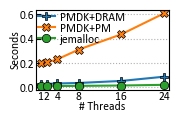

In [31]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (1.598, 1.0)
plt.rcParams["figure.subplot.left"] = 0.16
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.19
plt.rcParams["figure.subplot.top"] = 0.99
plt.rcParams["figure.subplot.wspace"] = 0.025

plt.rcParams["axes.labelpad"] = -0.8

df = pd.read_csv("parsed/allocation.csv")

ax = df.plot.line(x="Threads", y=["PMDK+DRAM", "PMDK+PM", "jemalloc"], style=["-P","-X","-o"], markersize=6)

plt.xlabel("# Threads")
plt.ylabel("Seconds")
ax.yaxis.set_ticks(numpy.arange(0, plt.ylim()[1], 0.2))
ax.xaxis.set_ticks(df.Threads)
plt.xlim(0,25)

ax.xaxis.grid(False)
    
ax.legend(loc="upper left", labelspacing=0, handlelength=1.5)
    
plt.savefig("plots/plot_alloc.pdf")

## A Peek Into The Future

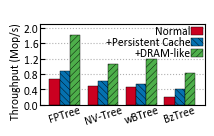

In [32]:
%matplotlib inline

from matplotlib.colors import LinearSegmentedColormap

my_style()

plt.rcParams["figure.figsize"] = (1.96, 1.0)
plt.rcParams["figure.subplot.left"] = 0.155
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.175
plt.rcParams["figure.subplot.top"] = 0.985
plt.rcParams["figure.subplot.wspace"] = 0.025

plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.major.pad"] = -1

cmap = matplotlib.cm.get_cmap("Set1")

custom_set1 = LinearSegmentedColormap.from_list("CustomSet1", ["#ca0020", "#0571b0", "#4daf4a"])
bar_width = 0.2

df = pd.read_csv("parsed/peek_future.csv")
ax = df.plot.bar(x="Tree", y=["Normal", "+Persistent Cache", "+DRAM-like"], colormap=custom_set1, width=bar_width*4, rot=18)

plt.xlabel("") # Remove X label
plt.ylabel("Throughput (Mop/s)     ")
ax.yaxis.set_ticks(numpy.arange(0, 2.4, 0.4))
plt.ylim(0,2.1)
ax.xaxis.grid(False)

bars = ax.patches
patterns =(" ", "\\\\\\\\\\", "/////")
hatches = [p for p in patterns for i in range(4)]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
ax.legend(loc="upper right", markerfirst=False, labelspacing=0, handlelength=1, handletextpad=0.075)
    
plt.savefig("plots/plot_peek_future.pdf")

## 2 DCPMM vs. 6 DCPMM

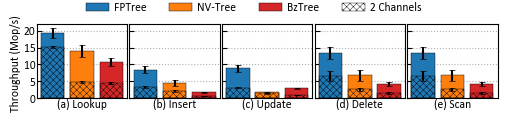

In [33]:
%matplotlib inline

my_style()

plt.rcParams["figure.figsize"] = (4.9, 1.0)
plt.rcParams["figure.subplot.left"] = 0.055
plt.rcParams["figure.subplot.right"] = 0.995
plt.rcParams["figure.subplot.bottom"] = 0.14
plt.rcParams["figure.subplot.top"] = 0.88
plt.rcParams["figure.subplot.wspace"] = 0.025

plt.rcParams["xtick.bottom"] = False

df = pd.read_csv("parsed/channels.csv")

workloads = df.Operation.drop_duplicates().to_list()
for wl in workloads:
    idx = workloads.index(wl)
    ax = plt.subplot(1,5,idx+1)

    df_6 = df.loc[(df.Operation == wl) & (df.Channels == 6)]
    plt.bar(x=0, height=df_6.loc[(df.Tree == "FPTree")].avg, yerr=df_6.loc[(df.Tree == "FPTree")].sd, label="FPTree", color="#1f77b4")
    plt.bar(x=1, height=df_6.loc[(df.Tree == "NV-Tree")].avg, yerr=df_6.loc[(df.Tree == "NV-Tree")].sd, label="NV-Tree", color="#ff7f0e")
    plt.bar(x=2, height=df_6.loc[(df.Tree == "BzTree")].avg, yerr=df_6.loc[(df.Tree == "BzTree")].sd, label="BzTree", color="#d62728")
    
    df_2 = df.loc[(df.Operation == wl) & (df.Channels == 2)]
    plt.bar(x=0, height=df_2.loc[(df.Tree == "FPTree")].avg, yerr=df_2.loc[(df.Tree == "FPTree")].sd, label="2 Channels", color="#ffffff00", hatch="xxxxx")
    plt.bar(x=1, height=df_2.loc[(df.Tree == "NV-Tree")].avg, yerr=df_2.loc[(df.Tree == "NV-Tree")].sd, color="#ffffff00", hatch="xxxxx")
    plt.bar(x=2, height=df_2.loc[(df.Tree == "BzTree")].avg, yerr=df_2.loc[(df.Tree == "BzTree")].sd, color="#ffffff00", hatch="xxxxx")
    
    plt.gca().set_title(label="("+chr(97+idx)+") "+wl, y=-0.175)
    plt.gca().yaxis.set_ticks(numpy.arange(0, 21, 5))
    plt.ylim(0,22)
    plt.gca().get_xaxis().set_ticks([])    # Remove xticks and xticklabels

# Remove yticklabels from all plots but the first one
for ax in plt.gcf().get_axes()[1:]:
    plt.setp(ax.get_yticklabels(), visible=False)

plt.gcf().get_axes()[0].set_ylabel("Throughput (Mop/s)  ")
handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc="upper center", ncol=4)
    
plt.savefig("plots/plot_tput_uniform_single_channels.pdf")